In [12]:
import torch 
import torch.nn as nn
import lightning as L
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, EnhancedMSELoss, EnhancedMSEMetric, PredictionPlottingCallback

from utility import loadData, PredictionData

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy.stats import pearsonr

In [2]:
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

# Matplotlib default settings
plt.rcParams.update({
    'figure.figsize': (10, 15),
    'savefig.dpi': 300,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
    'font.family': 'DejaVu Serif',
})


In [3]:
data, runoff = loadData()

In [4]:
modelParameters = {
"input_dim": 4,
"hidden_dim": 9,
"kernel_size": (7,7),
"num_layers": 1,
"batch_first": True,
"bias": True,
"return_all_layers": False,
"dimensions": (222,244),
"input_size": 30
}

pyTorchBaltNet = BaltNet(modelPar=modelParameters)

LightningBaltNet = LightningModel.load_from_checkpoint(
# checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive2TopOne-v2.ckpt",
#checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive3TopOne-v2.ckpt",
checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive5TopOne-v2.ckpt",
learning_rate=1e-3,
map_location="cpu",
model=pyTorchBaltNet,
cosine_t_max=100
)

In [5]:
# Used for the scaling of the NN prediction 
dataDataset = AtmosphericDataset(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    input_size=modelParameters["input_size"],
)

dataLoader = AtmosphereDataModule(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    batch_size=50,
    input_size=modelParameters["input_size"],
    num_workers=16
)

In [6]:
dataLoader.setup(stage="")

In [7]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
predictions = trainer.predict(LightningBaltNet, dataloaders=dataLoader.test_dataloader())

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [9]:
testData = np.zeros((len(dataLoader.test), 97))
iterater = iter(dataLoader.test)
for i in range(len(dataLoader.test)):
    batch = next(iterater)[1]
    testData[i,:] = batch
    

In [10]:
concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
rescaledRunoffData = concatenated_predictions*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data
rescaledTestData = testData*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data

In [11]:
runoffData = xr.Dataset(
    {
        "prediction":(("time", "river"), rescaledRunoffData),
        "original":(("time","river"), rescaledTestData)
    },
    coords={
        "time": np.arange(len(rescaledRunoffData)),
        "river":np.arange(97)
    }
)

In [69]:
Neva = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Neva.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Neva.index = pd.to_datetime(Neva.index)


In [77]:
Oder = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Odra.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Oder.index = pd.to_datetime(Oder.index)

In [78]:
Neman = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Neman.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Neman.index = pd.to_datetime(Neman.index)

In [79]:
UmeAlv = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/UmeAlv.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
UmeAlv.index = pd.to_datetime(UmeAlv.index)

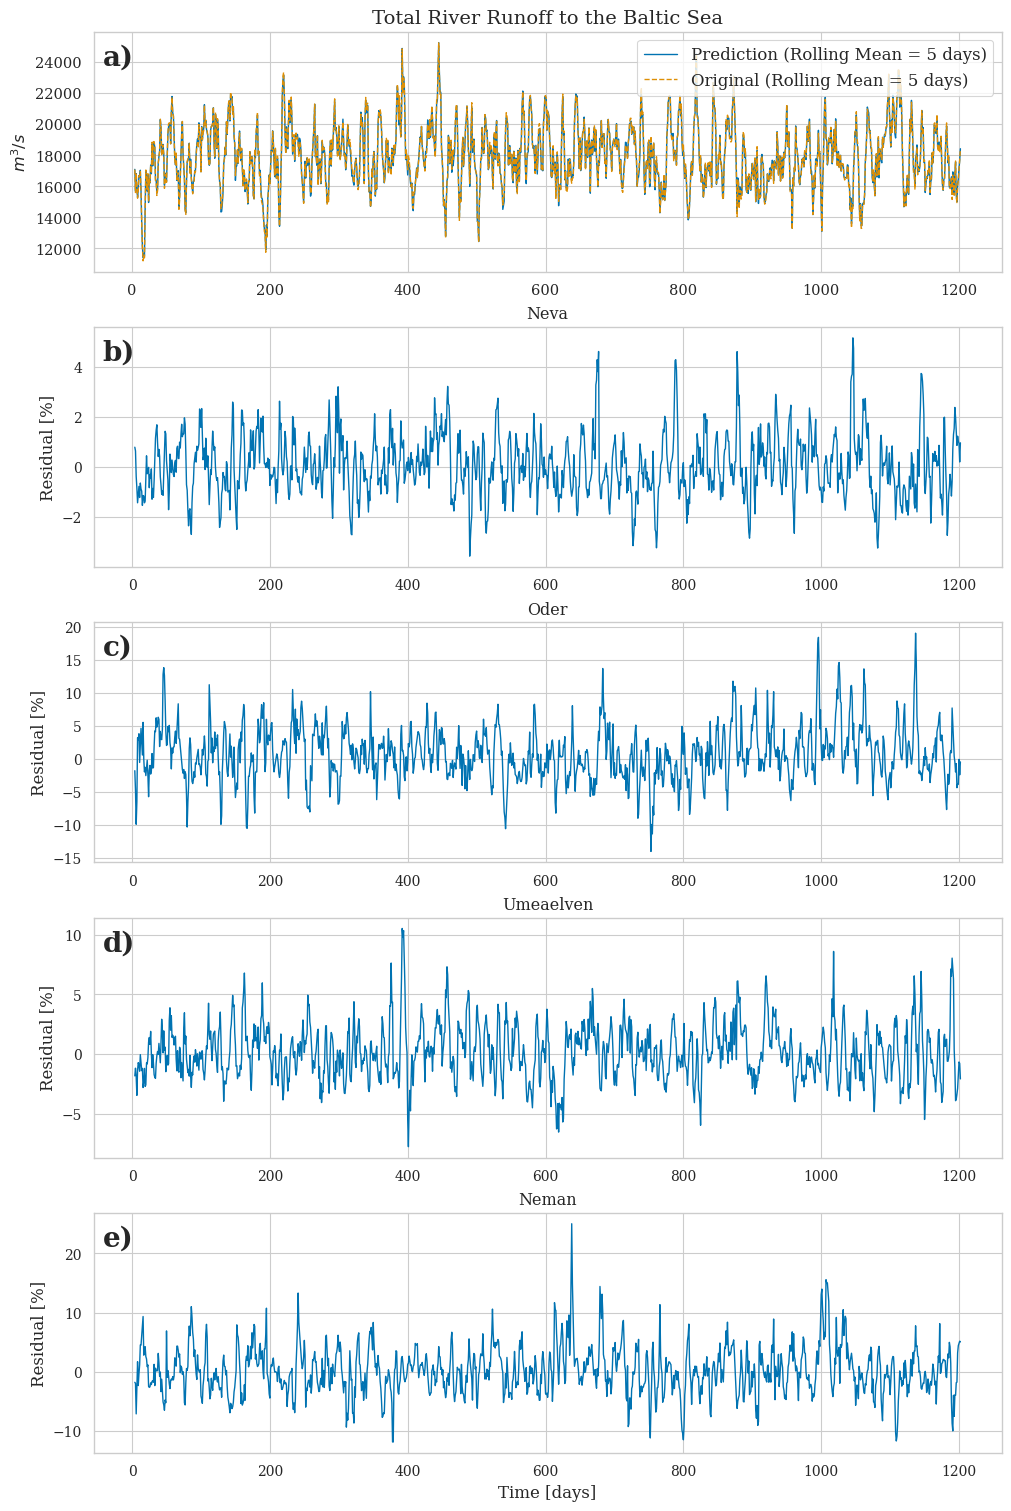

In [121]:
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

rolling_window_size = 5
fig = plt.figure(figsize=(10, 15),constrained_layout=True)
gs = fig.add_gridspec(nrows=5, ncols=1, left=0.05, right=0.95)

ax0 = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[i+1, 0], sharex=ax0) for i in range(4)]

runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().plot(ax=ax0, label=f'Prediction (Rolling Mean = {rolling_window_size} days)', linewidth=1)
runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().plot(ax=ax0, label=f'Original (Rolling Mean = {rolling_window_size} days)', linewidth=1, linestyle='--')
ax0.set_title('Total River Runoff to the Baltic Sea', fontsize=14)
ax0.set_ylabel("$m^3/s$")
ax0.set_xlabel("")
# Adjust legend outside the plot area for ax0
ax0.legend(fontsize=12, loc='upper right')
ax0.text(0.01, 0.95, 'a)', transform=ax0.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


annotations = ['b)', 'c)', 'd)', 'e)']  
largest_rivers = runoffData.sum(dim='time').to_array().sum(dim='variable').argsort()[::-1][0:4]

riversWithData = [56,2,78,15]

for i, river in enumerate(riversWithData):
    runoffData5d = runoffData.rolling(time=rolling_window_size).mean()
    residual = (runoffData5d.isel(river=river)['prediction'] - runoffData5d.sel(river=river)['original'])/runoffData5d.sel(river=river)['original']
    (residual*100).plot(ax=axes[i], label='Residual [%]', linewidth=1)
    # runoffData.sel(river=river)['prediction'].rolling(time=rolling_window_size).mean().plot(ax=axes[i], label='Prediction', linewidth=1)
    # runoffData.sel(river=river)['original'].rolling(time=rolling_window_size).mean().plot(ax=axes[i], label='Original', linewidth=1, linestyle='--')
    axes[i].text(0.01, 0.95, annotations[i], transform=axes[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


axes[3].set_title("Neman")
axes[2].set_title("Umeaelven")
axes[1].set_title("Oder")
axes[0].set_title("Neva")

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylabel("Residual [%]", fontsize=12)
    ax.set_xlabel("", fontsize=12)

ax.set_xlabel("Time [days]", fontsize=12)


fig.savefig("figures/paper_total_river_runoff.png", dpi=300)

In [99]:
listRiver = [Neva, Oder, UmeAlv, Neman]
riversWithData = [56,2,78,15]


<Axes: xlabel='Date'>

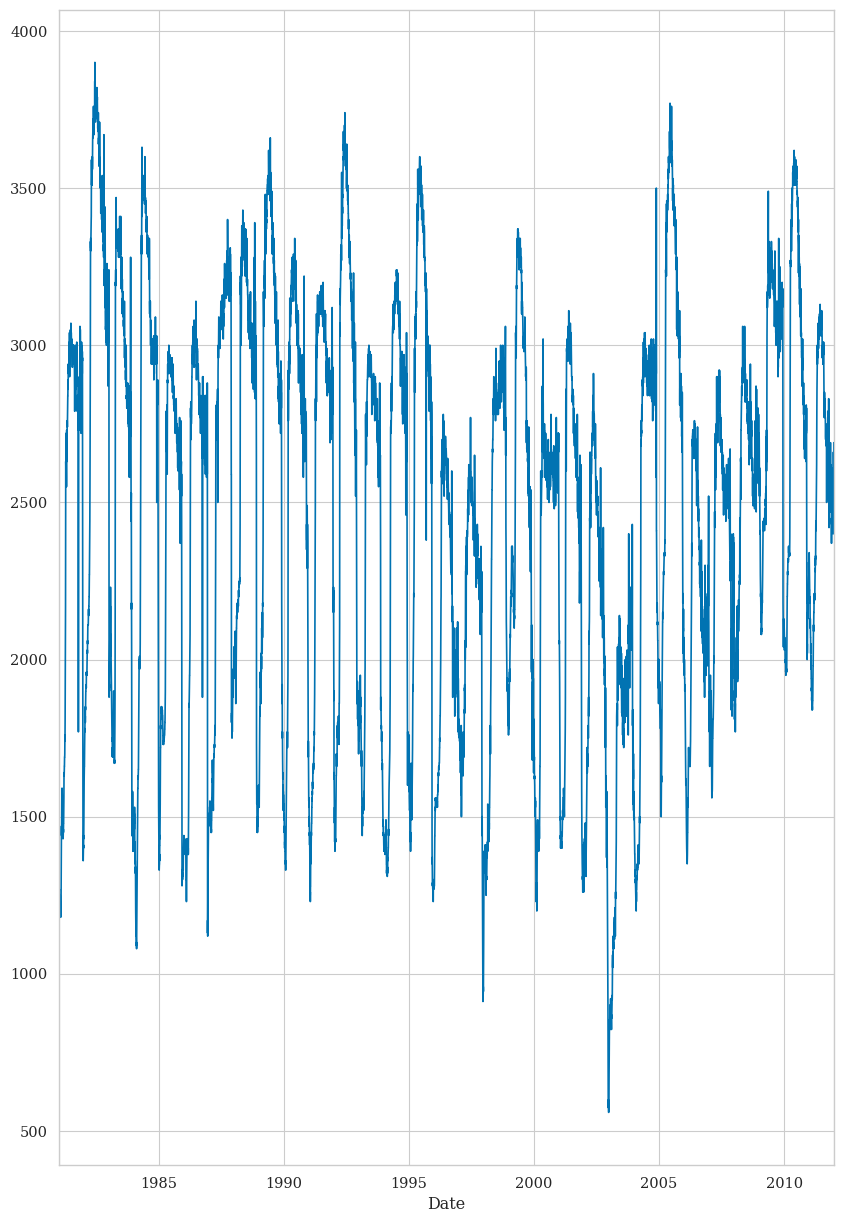

In [104]:
listRiver[0].loc["1981":"2011"].Calculated.plot()

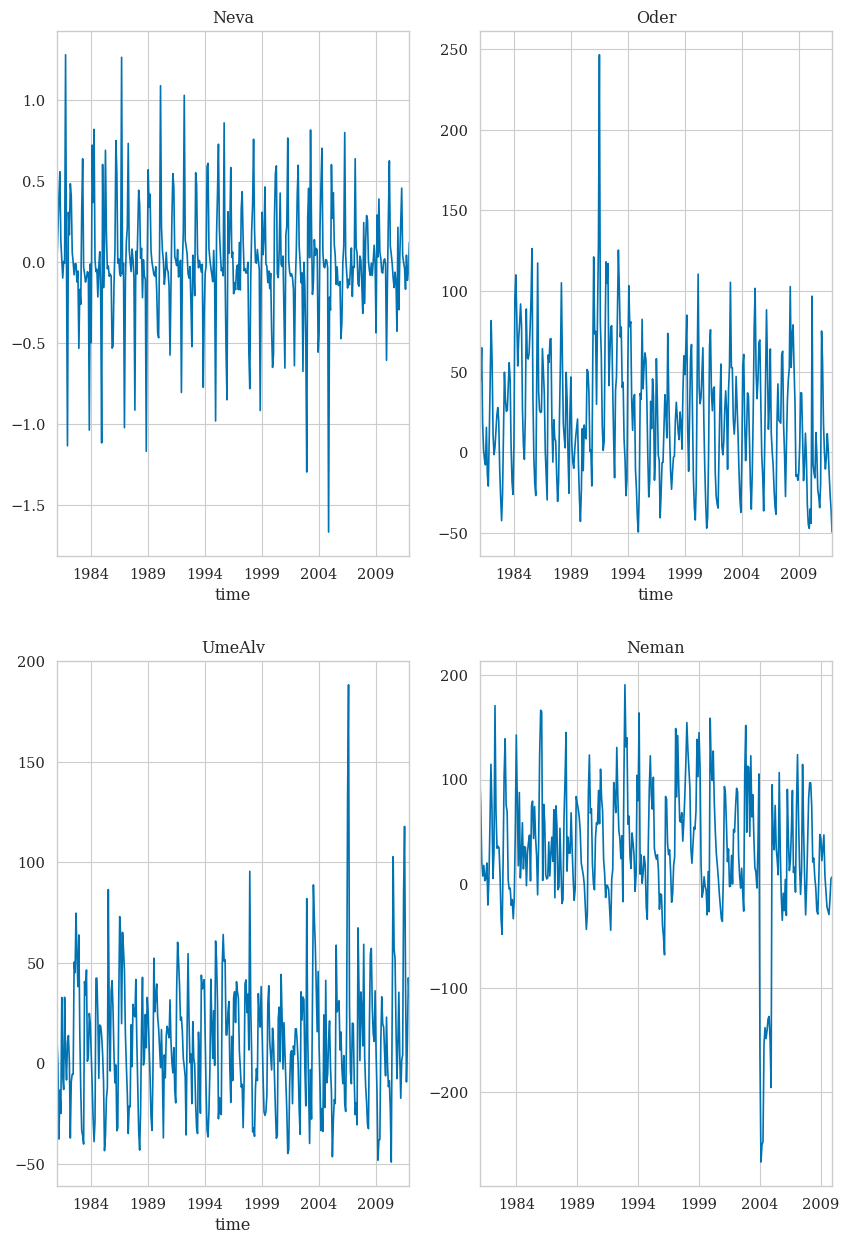

In [122]:
f, ax = plt.subplots(2, 2)
ax = ax.ravel()

listRiverNames = ["Neva", "Oder", "UmeAlv", "Neman"]


for i in range(4):
    resampledRunoffSelect = runoff.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
    resampledMeasurements = listRiver[i].loc["1981":"2011"].Calculated.resample("M").sum()
    
    aligned_df = resampledRunoffSelect.join(resampledMeasurements, how='inner')
    aligned_df['Residuals'] = (aligned_df['Runoff'] - aligned_df['Calculated'])/resampledMeasurements

    (aligned_df['Residuals']*100).plot(ax=ax[i])
    ax[i].set_title(f"{listRiverNames[i]}")



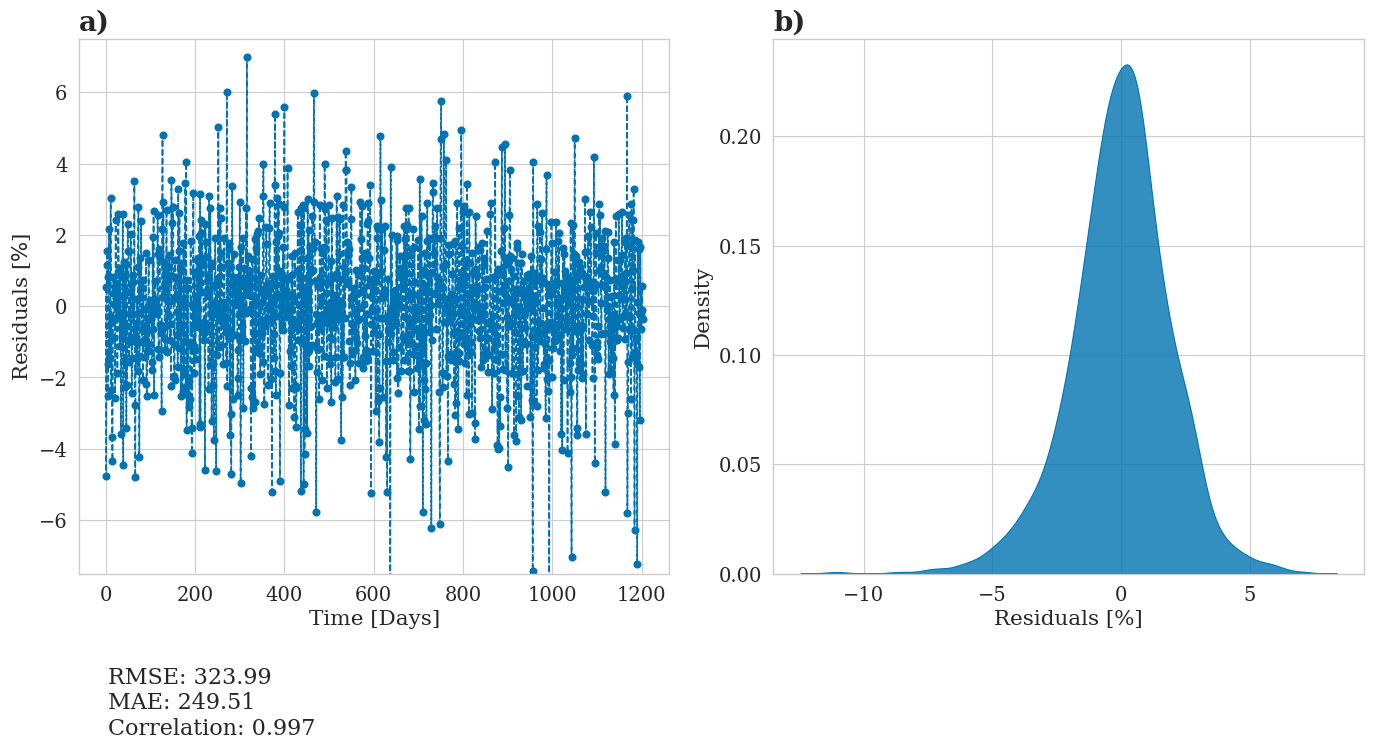

In [ ]:


# Assuming 'runoffData' and 'rolling_window_size' are defined
# Placeholder for 'runoffData' structure, replace with your actual data loading logic

rolling_window_size = 1


def calculate_rmse(original, prediction):
    return np.sqrt(np.mean((original - prediction) ** 2))

def calculate_mae(original, prediction):
    return np.mean(np.abs(original - prediction))

def calculate_correlation(original, prediction):
    corr, _ = pearsonr(original, prediction)
    return corr

# Sum over all rivers and calculate rolling mean
summed_pred = runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')
summed_orig = runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')

# Calculate metrics
rmse_val = calculate_rmse(summed_orig, summed_pred)
mae_val = calculate_mae(summed_orig, summed_pred)
correlation_val = calculate_correlation(summed_orig, summed_pred)

# Plotting
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.6)
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(14, 8))

metrics_text = f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}\nCorrelation: {correlation_val:.3f}'

# Residual plot
residuals = summed_orig - summed_pred
residualsPct = residuals / summed_orig * 100
ax2.plot(summed_orig.time.values, residualsPct, marker='o', linestyle='--')
ax2.set_xlabel('Time [Days]')
ax2.set_ylabel('Residuals [$\%$]')
ax2.set_title('a)', loc="left", fontsize=20, fontweight="bold")
ax2.set_ylim([-7.5,7.5])
ax2.annotate(metrics_text, xy=(0.05, -0.3), xycoords='axes fraction', fontsize=16, bbox=dict(boxstyle="round", fc="w"))

# Density plot for residuals
sns.kdeplot(residuals/summed_orig * 100, alpha=0.8, ax=ax3, fill=True)
ax3.set_xlabel('Residuals [%]')
x
fig.tight_layout()
fig.savefig("figures/paper_error_metrics.png", dpi=300)

In [ ]:
WarnowriverRunoff = "/silod5/boergel/ocean_models_forcing/MOM_UERRA_FORCING/e-hype-runoff-raw/combined_fastriver_006.nc"